Convolutional Networks (ConvNets)
======

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_epochs = 20
batch_size = 128
learning_rate = 1e-3
use_dropout = False
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

ConvNet Definition
-----------------------
Compare the number of parameters to the multi-layer perceptron: the convnet has less than 5% of the MLPs parameters.

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1) # out: 8 x 14 x 14
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1) # out: 16 x 7 x 7
        self.conv3 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 3 x 3
        if use_dropout:
            self.do1 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(288, 50)
        if use_dropout:
            self.do2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(50, 10) # 10 outputs: probability for each digit class

    def forward(self, x):
        # convolutional part
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        if use_dropout:
            x = self.do1(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        
        # fully connected part
        x = F.relu(self.fc1(x))
        if use_dropout:
            x = self.do2(x)
        x = F.log_softmax(self.fc2(x), dim=1) # last activation is log softmax to get log class probabilities
        
        return x

convnet = ConvNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
convnet = convnet.to(device)

num_params = sum(p.numel() for p in convnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 25384


Train ConvNet
--------


In [5]:
optimizer = torch.optim.Adam(params=convnet.parameters(), lr=learning_rate)

# set to training mode
convnet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, label_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        
        # class predictions
        prediction_batch = convnet(image_batch)
        
        # The cross-entropy loss.
        # The first input are the predicted log class probabilities.
        # The ground truth probabilites for each image are expected to be
        # 1 for a single class and 0 for all other classes.
        # This function expects as second input the index of the class with probability 1.
        # (this function is not called cross-entropy, since this function assumes
        # that the inputs are log probabilities, not probabilities).
        loss = F.nll_loss(prediction_batch, label_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 20] average loss: 0.451211
Epoch [2 / 20] average loss: 0.132591
Epoch [3 / 20] average loss: 0.085536
Epoch [4 / 20] average loss: 0.065325
Epoch [5 / 20] average loss: 0.053001
Epoch [6 / 20] average loss: 0.045612
Epoch [7 / 20] average loss: 0.040013
Epoch [8 / 20] average loss: 0.034290
Epoch [9 / 20] average loss: 0.031025
Epoch [10 / 20] average loss: 0.027953
Epoch [11 / 20] average loss: 0.023873
Epoch [12 / 20] average loss: 0.022798
Epoch [13 / 20] average loss: 0.020652
Epoch [14 / 20] average loss: 0.017022
Epoch [15 / 20] average loss: 0.015603
Epoch [16 / 20] average loss: 0.014711
Epoch [17 / 20] average loss: 0.013669
Epoch [18 / 20] average loss: 0.012789
Epoch [19 / 20] average loss: 0.010842
Epoch [20 / 20] average loss: 0.010722


Plot Training Curve
--------------------

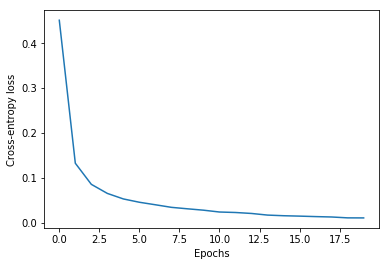

In [6]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

Alternatively: Load Pre-Trained Model
-----------------------------

In [7]:
filename = 'convolutional_network.pth'
# filename = 'convolutional_network_dropout.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
convnet.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the model parameters can be saved:
# torch.save(convnet.state_dict(), './pretrained/my_convolutional_network.pth')

Evaluate on the Test Set
-------------------------

The best current methods achieve a classification error percentage of around 0.21%. See [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354) for a leaderboard.

Compared to the multi-layer perceptron, the convnet achieves less error using roughly 4% as many parameters.

Also notice that there is some overfitting: the average loss is significantly higher than for the training set.
Overfitting can be reduced by adding dropout between the fully connected layers. Retrain with `use_dropout` set to `True` or load the pre-trained `convolutional_network_dropout.pth` to see the difference.

In [8]:
# set to evaluation mode
convnet.eval()

num_incorrect = 0
test_loss_avg = 0
num_batches = 0
num_instances = 0
for image_batch, label_batch in test_dataloader:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # class predictions
        prediction_batch = convnet(image_batch)

        # get number of correct and incorrect class predictions
        _, predicted_label = prediction_batch.max(dim=1)
        num_incorrect += (predicted_label != label_batch).sum().item()

        # cross-entropy loss
        loss = F.nll_loss(prediction_batch, label_batch)

        test_loss_avg += loss.item()
        num_batches += 1
        num_instances += image_batch.size(0)
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('classification error: %f%%' % ((num_incorrect / num_instances)*100))

average loss: 0.048213
classification error: 1.250000%
